# Experiments Notebook

This notebook contains various types of experiments to help build the final model

## Imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# Pre processing

## Read data

In [9]:
df = pd.read_csv("./data/training.csv", sep="\t", na_values=["(null)"])

In [10]:
df.head()

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0
4,01/10/2016,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0


## Clean data

In [11]:
df["DepartureDate"] = df["DepartureDate"].astype("datetime64[us]")

In [12]:
df.isnull().sum() / df.shape[0]

DepartureDate       0.000000
DepartureYear       0.000000
DepartureMonth      0.000000
DepartureDay        0.000000
FlightNumber        0.000000
DepartureAirport    0.000000
ArrivalAirport      0.000000
Route               0.000000
ActualFlightTime    0.000000
ActualTotalFuel     0.000000
ActualTOW           0.014564
FLownPassengers     0.003195
BagsCount           0.076822
FlightBagsWeight    0.083347
dtype: float64

In [13]:
# Delate, rows with nan in target col
df = df.dropna(subset=["ActualTOW"])

In [14]:
df.columns

Index(['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay',
       'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route',
       'ActualFlightTime', 'ActualTotalFuel', 'ActualTOW', 'FLownPassengers',
       'BagsCount', 'FlightBagsWeight'],
      dtype='object')

In [15]:
df_cleaned = df[
    (df["ActualFlightTime"].isna() | (df["ActualFlightTime"] < 1080)) &
    (df["ActualTotalFuel"].isna() | (df["ActualTotalFuel"] < 14000)) &
    (df["BagsCount"].isna() | (df["BagsCount"] < 300)) &
    (df["FlightBagsWeight"].isna() | (df["FlightBagsWeight"] < 2200))
]

In [16]:
df_cleaned.isnull().sum() / df_cleaned.shape[0]

DepartureDate       0.000000
DepartureYear       0.000000
DepartureMonth      0.000000
DepartureDay        0.000000
FlightNumber        0.000000
DepartureAirport    0.000000
ArrivalAirport      0.000000
Route               0.000000
ActualFlightTime    0.000000
ActualTotalFuel     0.000000
ActualTOW           0.000000
FLownPassengers     0.002051
BagsCount           0.074946
FlightBagsWeight    0.081474
dtype: float64

## new fetures

In [19]:
# df_cleaned['BagsCount_missing'] = df['BagsCount'].isna()
# df_cleaned['FlightBagsWeight_missing'] = df['FlightBagsWeight'].isna()

In [20]:
# df_cleaned = create_new_features(df_cleaned)

In [21]:
df_cleaned

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,2016-01-10,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,2016-01-10,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0
2,2016-01-10,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN
3,2016-01-10,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0
4,2016-01-10,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,2016-10-15,2016,10,15,9833,PMI,HHN,PMI-HHN,102,4880,66247.0,177.0,96.0,1250.0
29727,2016-10-15,2016,10,15,9862,LPL,AGP,LPL-AGP,163,6890,67898.0,185.0,107.0,1390.0
29728,2016-10-15,2016,10,15,9863,AGP,LPL,AGP-LPL,145,6322,66247.0,172.0,64.0,830.0
29729,2016-10-15,2016,10,15,9948,FAO,ORK,FAO-ORK,132,5880,68224.0,183.0,82.0,1090.0


## Train Test Split

In [22]:
data = df_cleaned

In [23]:
data.columns

Index(['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay',
       'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route',
       'ActualFlightTime', 'ActualTotalFuel', 'ActualTOW', 'FLownPassengers',
       'BagsCount', 'FlightBagsWeight'],
      dtype='object')

In [24]:
# Podział na X (cechy) i y (etykieta)
X = data.drop(columns= ['ActualTOW', 'DepartureDate', 'DepartureYear', 'DepartureMonth','DepartureDay',
       'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route'])
y = data['ActualTOW']

# Podział na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X.head()

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,91,3660,175.0,61.0,440.0
1,68,3280,182.0,27.0,350.0
2,64,2720,127.0,NaN,NaN
3,35,1682,163.0,12.0,150.0
4,34,1877,178.0,37.0,490.0


In [26]:
y.head()

0    64016.0
1    66138.0
2    58447.0
3    60587.0
4    63090.0
Name: ActualTOW, dtype: float64

# Experiments

## Testing different data imputation strategies

This experiment is designed to test different strategies for importing missing data. In our data set, such missing data exist. In particular, in the `BagsCount` and `FlightBagsWeight` columns. 
* Previous analyses have shown that these columns are highly correlated with each other. 
* It would be quite simple and highly effective to supplement these values by looking at the opposite value, among others. Unfortunately, the vast majority of cases involve missing both values at once. 
* This raises some difficulties in choosing the right way to impute the data. I decided to test several approaches based on which one best affects the models' results.

In [27]:
# 1. Imputacja tylko na danych treningowych
imputer_median = SimpleImputer(strategy="median")
imputer_mean = SimpleImputer(strategy="mean")
imputer_knn = KNNImputer(n_neighbors=10)
imputer_mice = IterativeImputer(random_state=42, max_iter=10)

imputers = {"median":imputer_median, "mean":imputer_mean, "knn":imputer_knn, "mice":imputer_mice}

/home/szczepan/miniconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/tmp/ipykernel_2372/1006612146.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_2372/1006612146.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


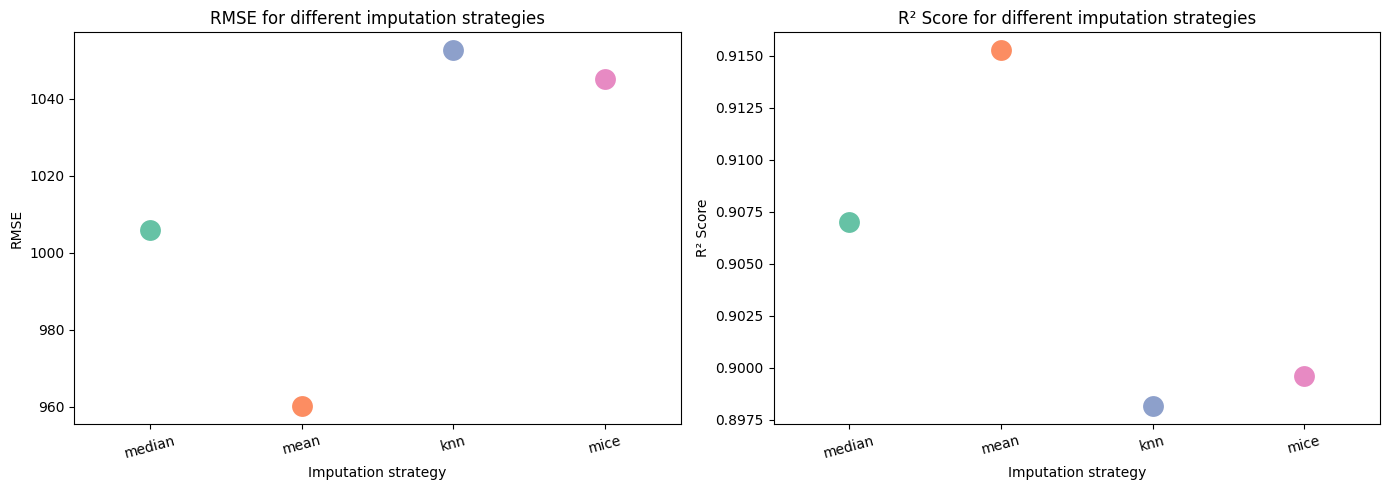

In [28]:
results = []
imputed_dfs = {}

model = RandomForestRegressor(random_state=42)

for name, imputer in imputers.items():
    # missing data imputation
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)

    X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
    imputed_dfs[name] = X_train_imputed_df.copy()

    # Training and predictions
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_val_imputed)

    # Eval 
    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        "Imputation": name,
        "RMSE": rmse,
        "R2 Score": r2
    })

# Dataframe from rezults (for plots)
results_df = pd.DataFrame(results)


# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Stripplot RMSE
sns.stripplot(
    data=results_df,
    x="Imputation",
    y="RMSE",
    palette="Set2",
    size=15,
    ax=axes[0]
)
axes[0].set_title("RMSE for different imputation strategies")
axes[0].set_ylabel("RMSE")
axes[0].set_xlabel("Imputation strategy")
axes[0].tick_params(axis='x', rotation=15)

# Stripplot R²
sns.stripplot(
    data=results_df,
    x="Imputation",
    y="R2 Score",
    palette="Set2",
    size=15,
    ax=axes[1]
)
axes[1].set_title("R² Score for different imputation strategies")
axes[1].set_ylabel("R² Score")
axes[1].set_xlabel("Imputation strategy")
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

#### NOTE:
This experiment showed that the best strategy for filling in missing data is the average. Of course, it is based on the results of the model. Looking at the approximation to the distribution of features, it would probably work better to use KNN or MICE. 

## Testing different regression models

This experiment is to see if there is a type of model that will stand out for our dataset, so that better results can be obtained.

### Model Descriptions

#### Linear Regression

Linear Regression is a simple and interpretable model that assumes a linear relationship between the features and the target variable. It's useful as a baseline to compare more complex models. However, it struggles with capturing non-linear patterns and interactions between features.

#### Random Forest

Random Forest is an ensemble of decision trees that reduces overfitting by averaging the predictions of multiple trees. It handles non-linear relationships well and is robust to outliers and noise. It's a good choice for tabular data, though it can be less efficient with large datasets.

#### Gradient Boosting

Gradient Boosting builds trees sequentially, where each new tree focuses on correcting the errors of the previous ones. It often achieves high accuracy and handles complex patterns effectively. However, it requires careful tuning and is more prone to overfitting than Random Forest.

#### LightGBM

LightGBM is a gradient boosting framework optimized for speed and efficiency. It uses histogram-based algorithms and leaf-wise tree growth, which makes it faster and often more accurate than traditional boosting methods. It performs particularly well on large datasets with many features.

/home/szczepan/miniconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 20482, number of used features: 5
[LightGBM] [Info] Start training from score 65021.319891


/tmp/ipykernel_2372/1309272255.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_2372/1309272255.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


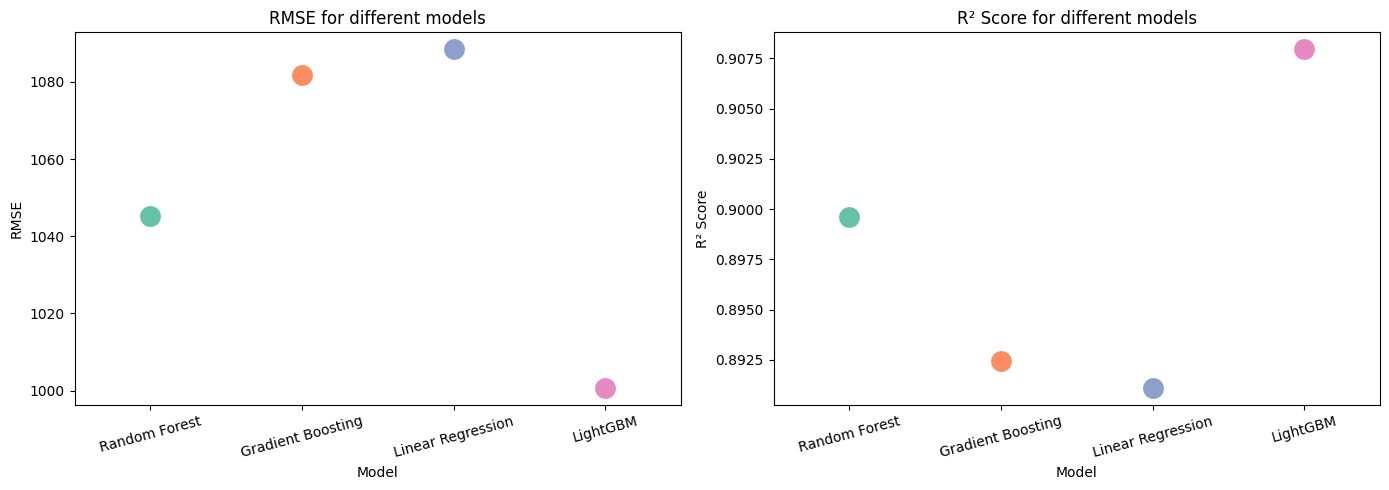

In [30]:
# input nan values
imputer_mean = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Choosen model 
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "LightGBM": LGBMRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_val_imputed)

    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R2 Score": r2
    })

# df with results
results_df = pd.DataFrame(results)

# plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stripplot RMSE
sns.stripplot(
    data=results_df,
    x="Model",
    y="RMSE",
    palette="Set2",
    size=15,
    ax=axes[0]
)
axes[0].set_title("RMSE for different models")
axes[0].set_ylabel("RMSE")
axes[0].set_xlabel("Model")
axes[0].tick_params(axis='x', rotation=15)

# Stripplot R²
sns.stripplot(
    data=results_df,
    x="Model",
    y="R2 Score",
    palette="Set2",
    size=15,
    ax=axes[1]
)
axes[1].set_title("R² Score for different models")
axes[1].set_ylabel("R² Score")
axes[1].set_xlabel("Model")
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

Light gbm achieved the best results in this case, with Random Forest in second place, followed by Gradient Boosting and Linear Regression.  

## Comparison of models and replenishment strategies at once 

In [31]:
imputer_median = SimpleImputer(strategy="median")
imputer_mean = SimpleImputer(strategy="mean")
imputer_knn = KNNImputer(n_neighbors=10)
imputer_mice = IterativeImputer(random_state=42, max_iter=10)

imputers = {"median":imputer_median, "mean":imputer_mean, "knn":imputer_knn, "mice":imputer_mice}

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "LightGBM": LGBMRegressor(random_state=42)
}


results = []


for imp_name, imputer in imputers.items():
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)

    for model_name, model in models.items():
        model.fit(X_train_imputed, y_train)
        y_pred = model.predict(X_val_imputed)

        rmse = root_mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        results.append({
            "Imputer": imp_name,
            "Model": model_name,
            "RMSE": rmse,
            "R2": r2
        })


results_df = pd.DataFrame(results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 20482, number of used features: 5
[LightGBM] [Info] Start training from score 65021.319891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 20482, number of used features: 5
[LightGBM] [Info] Start training from score 65021.319891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

/home/szczepan/miniconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 20482, number of used features: 5
[LightGBM] [Info] Start training from score 65021.319891


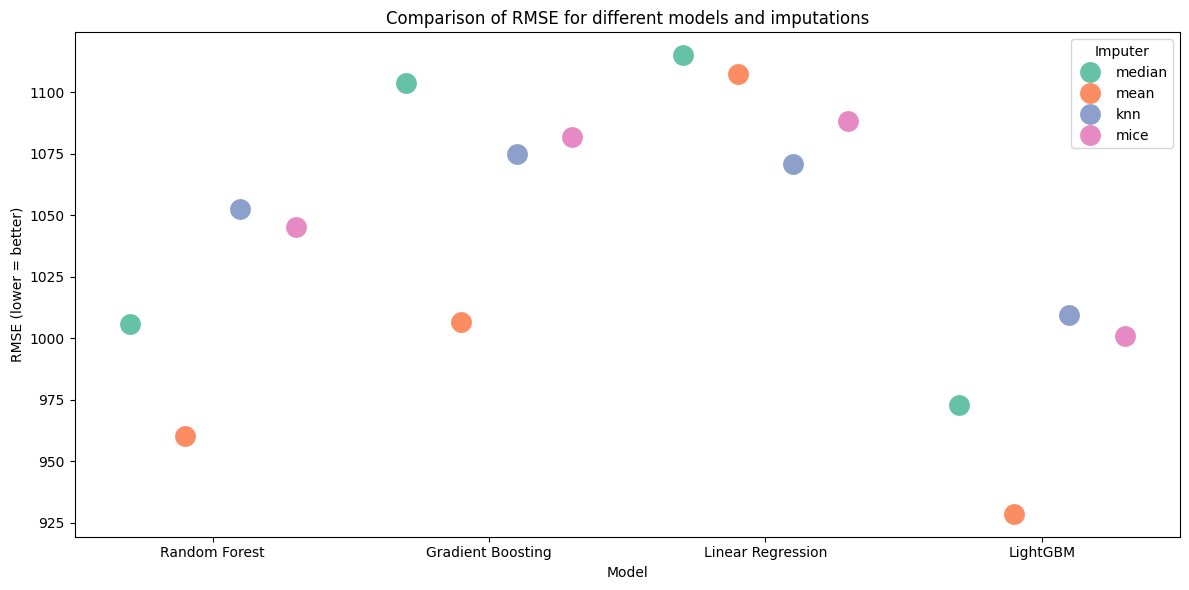

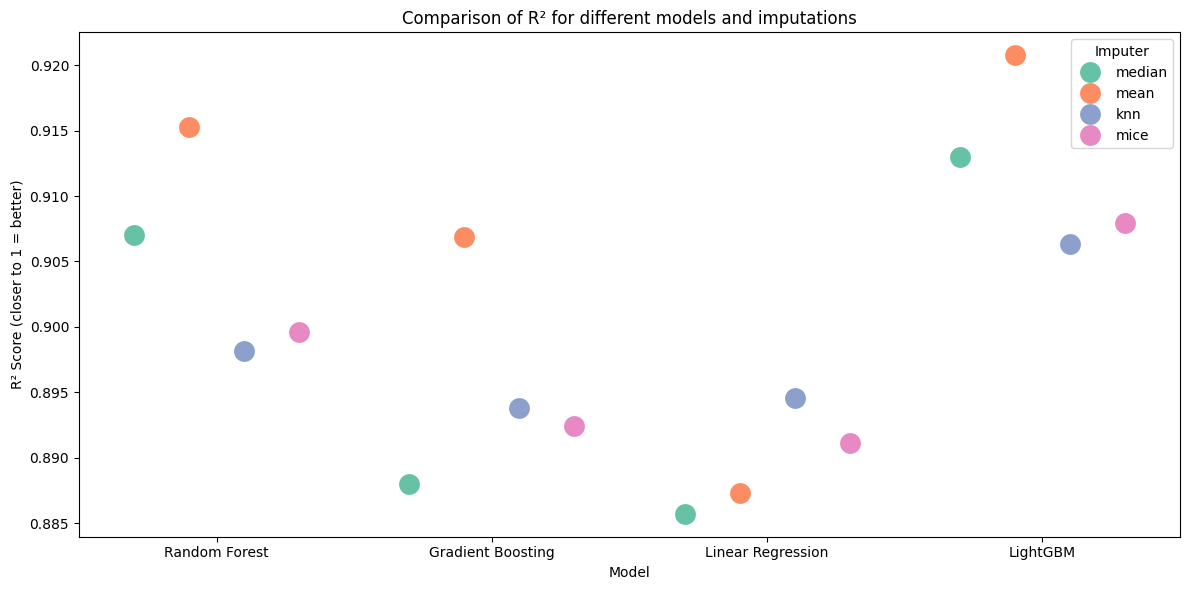

In [32]:
# Plot: RMSE
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=results_df,
    x="Model",
    y="RMSE",
    hue="Imputer",
    dodge=True,
    jitter=True,
    palette="Set2",
    size=15
)
plt.title("Comparison of RMSE for different models and imputations")
plt.ylabel("RMSE (lower = better)")
plt.xlabel("Model")
plt.legend(title="Imputer")
plt.tight_layout()
plt.show()

# Plot: R²
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=results_df,
    x="Model",
    y="R2",
    hue="Imputer",
    dodge=True,
    jitter=True,
    palette="Set2",
    size=15
)
plt.title("Comparison of R² for different models and imputations")
plt.ylabel("R² Score (closer to 1 = better)")
plt.xlabel("Model")
plt.legend(title="Imputer")
plt.tight_layout()
plt.show()

## Testing new fetures

This experiment is to test various ideas for new features that can help better results for the model


In [ ]:
def create_new_features(df_input):
    df = df_input.copy()


    # --- 1. Payload-Related Features ---
    # Average Bag Weight per Bag
    df['AvgBagWeightPerBag'] = np.where(
        df['BagsCount'] > 0,
        df['FlightBagsWeight'] / df['BagsCount'],
        0 
    )

    # Bags per Passenger
    df['BagsPerPassenger'] = np.where(
        df['FLownPassengers'] > 0,
        df['BagsCount'] / df['FLownPassengers'],
        0 
    )

    # Total items (passengers + bags)
    df['TotalPassengerBagItems'] = df['FLownPassengers'] + df['BagsCount']

    # --- 2. Fuel Efficiency / Consumption Ratios ---
    # Fuel per Passenger
    df['FuelPerPassenger'] = np.where(
        df['FLownPassengers'] > 0,
        df['ActualTotalFuel'] / df['FLownPassengers'],
        0 
    )

    # Fuel per Flight Minute
    # ActualFlightTime is likely in minutes.
    df['FuelPerFlightMinute'] = np.where(
        df['ActualFlightTime'] > 0,
        df['ActualTotalFuel'] / df['ActualFlightTime'],
        0 
    )

    # Fuel per Bag Weight
    df['FuelPerBagWeightUnit'] = np.where(
        df['FlightBagsWeight'] > 0,
        df['ActualTotalFuel'] / df['FlightBagsWeight'],
        0 
    )

    # --- 3. Flight Characteristics & Interactions ---
    # Interaction: Flight Time and Passengers
    df['FlightTime_x_Passengers'] = df['ActualFlightTime'] * df['FLownPassengers']


    # --- 4. Polynomial Features (for potentially non-linear relationships) ---
    df['ActualTotalFuel_sq'] = df['ActualTotalFuel']**2
    df['ActualFlightTime_sq'] = df['ActualFlightTime']**2
    df['FLownPassengers'] = df['FLownPassengers']**2
    df['FlightBagsWeight_sq'] = df['FlightBagsWeight']**2


    # --- Derived feature related to payload and fuel ---
    AVG_PASSENGER_WEIGHT_KG = 70 # This is an arbitrary assumption
    df['EstimatedPayloadWeight'] = (df['FLownPassengers'] * AVG_PASSENGER_WEIGHT_KG) + df['FlightBagsWeight']

    # Ratio of Fuel to Estimated Payload
    df['FuelToPayloadRatio'] = np.where(
        df['EstimatedPayloadWeight'] > 0,
        df['ActualTotalFuel'] / df['EstimatedPayloadWeight'],
        0 
    )


    # Ratio of flight time to fuel
    df['FlightTimePerFuelUnit'] = np.where(
        df['ActualTotalFuel'] > 0,
        df['ActualFlightTime'] / df['ActualTotalFuel'],
        0
    )


    return df

In [34]:
# input nan values
imputer_mean = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_val_imputed_df = pd.DataFrame(X_val_imputed, columns=X_val.columns, index=X_val.index)

/home/szczepan/miniconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [35]:
X_train_with_fetures = create_new_features(X_train_imputed_df)

X_val_with_fetures = create_new_features(X_val_imputed_df)

In [36]:
X_train_with_fetures

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,AvgBagWeightPerBag,BagsPerPassenger,TotalPassengerBagItems,FuelPerPassenger,FuelPerFlightMinute,FuelPerBagWeightUnit,FlightTime_x_Passengers,ActualTotalFuel_sq,ActualFlightTime_sq,FlightBagsWeight_sq,EstimatedPayloadWeight,FuelToPayloadRatio,FlightTimePerFuelUnit
20190,218.0,9355.0,32400.0,24.000000,352.549561,14.689565,0.133333,204.000000,51.972222,42.912844,26.535276,39240.0,87516025.0,47524.0,1.242912e+05,2.268353e+06,0.004124,0.023303
2947,152.0,6929.0,32761.0,57.432894,741.790954,12.915786,0.317309,238.432894,38.281768,45.585526,9.340907,27512.0,48011041.0,23104.0,5.502538e+05,2.294012e+06,0.003020,0.021937
15430,92.0,4073.0,25281.0,27.000000,351.000000,13.000000,0.169811,186.000000,25.616352,44.271739,11.603989,14628.0,16589329.0,8464.0,1.232010e+05,1.770021e+06,0.002301,0.022588
2228,55.0,2670.0,31684.0,23.000000,300.000000,13.043478,0.129213,201.000000,15.000000,48.545455,8.900000,9790.0,7128900.0,3025.0,9.000000e+04,2.218180e+06,0.001204,0.020599
25452,55.0,2630.0,24649.0,17.000000,220.000000,12.941176,0.108280,174.000000,16.751592,47.818182,11.954545,8635.0,6916900.0,3025.0,4.840000e+04,1.725650e+06,0.001524,0.020913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21897,131.0,5810.0,31329.0,39.000000,500.000000,12.820513,0.220339,216.000000,32.824859,44.351145,11.620000,23187.0,33756100.0,17161.0,2.500000e+05,2.193530e+06,0.002649,0.022547
5454,101.0,4840.0,29241.0,26.000000,340.000000,13.076923,0.152047,197.000000,28.304094,47.920792,14.235294,17271.0,23425600.0,10201.0,1.156000e+05,2.047210e+06,0.002364,0.020868
872,127.0,5310.0,27889.0,69.000000,899.000000,13.028986,0.413174,236.000000,31.796407,41.811024,5.906563,21209.0,28196100.0,16129.0,8.082010e+05,1.953129e+06,0.002719,0.023917
16023,69.0,3000.0,19881.0,35.000000,460.000000,13.142857,0.248227,176.000000,21.276596,43.478261,6.521739,9729.0,9000000.0,4761.0,2.116000e+05,1.392130e+06,0.002155,0.023000


In [37]:
X_val_with_fetures

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,AvgBagWeightPerBag,BagsPerPassenger,TotalPassengerBagItems,FuelPerPassenger,FuelPerFlightMinute,FuelPerBagWeightUnit,FlightTime_x_Passengers,ActualTotalFuel_sq,ActualFlightTime_sq,FlightBagsWeight_sq,EstimatedPayloadWeight,FuelToPayloadRatio,FlightTimePerFuelUnit
6207,104.0,4472.0,26569.0,27.0,350.0,12.962963,0.165644,190.0,27.435583,43.000000,12.777143,16952.0,19998784.0,10816.0,122500.0,1860180.0,0.002404,0.023256
17348,103.0,4540.0,35344.0,12.0,140.0,11.666667,0.063830,200.0,24.148936,44.077670,32.428571,19364.0,20611600.0,10609.0,19600.0,2474220.0,0.001835,0.022687
6218,62.0,2730.0,9409.0,17.0,220.0,12.941176,0.175258,114.0,28.144330,44.032258,12.409091,6014.0,7452900.0,3844.0,48400.0,658850.0,0.004144,0.022711
28703,142.0,6340.0,35721.0,47.0,610.0,12.978723,0.248677,236.0,33.544974,44.647887,10.393443,26838.0,40195600.0,20164.0,372100.0,2501080.0,0.002535,0.022397
21277,107.0,4499.0,10000.0,17.0,220.0,12.941176,0.170000,117.0,44.990000,42.046729,20.450000,10700.0,20241001.0,11449.0,48400.0,700220.0,0.006425,0.023783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29649,269.0,11578.0,32761.0,100.0,1300.0,13.000000,0.552486,281.0,63.966851,43.040892,8.906154,48689.0,134050084.0,72361.0,1690000.0,2294570.0,0.005046,0.023234
16924,77.0,3450.0,31684.0,62.0,806.0,13.000000,0.348315,240.0,19.382022,44.805195,4.280397,13706.0,11902500.0,5929.0,649636.0,2218686.0,0.001555,0.022319
22819,45.0,2090.0,24649.0,29.0,380.0,13.103448,0.184713,186.0,13.312102,46.444444,5.500000,7065.0,4368100.0,2025.0,144400.0,1725810.0,0.001211,0.021531
366,133.0,6010.0,29241.0,64.0,860.0,13.437500,0.374269,235.0,35.146199,45.187970,6.988372,22743.0,36120100.0,17689.0,739600.0,2047730.0,0.002935,0.022130


In [38]:
cols = ["FlightTime_x_Passengers", "TotalPassengerBagItems", "EstimatedPayloadWeight", "FuelPerFlightMinute", "FlightTimePerFuelUnit", "ActualTotalFuel_sq"]

In [44]:
cols_to_drop = ["ActualFlightTime_sq", "ActualFlightTime"]

In [47]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_with_fetures.drop(columns=cols_to_drop), y_train)

RandomForestRegressor(random_state=42)

In [48]:
y_pred = model.predict(X_val_with_fetures.drop(columns=cols_to_drop))
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE:", rmse)

RMSE: 973.6514072372839


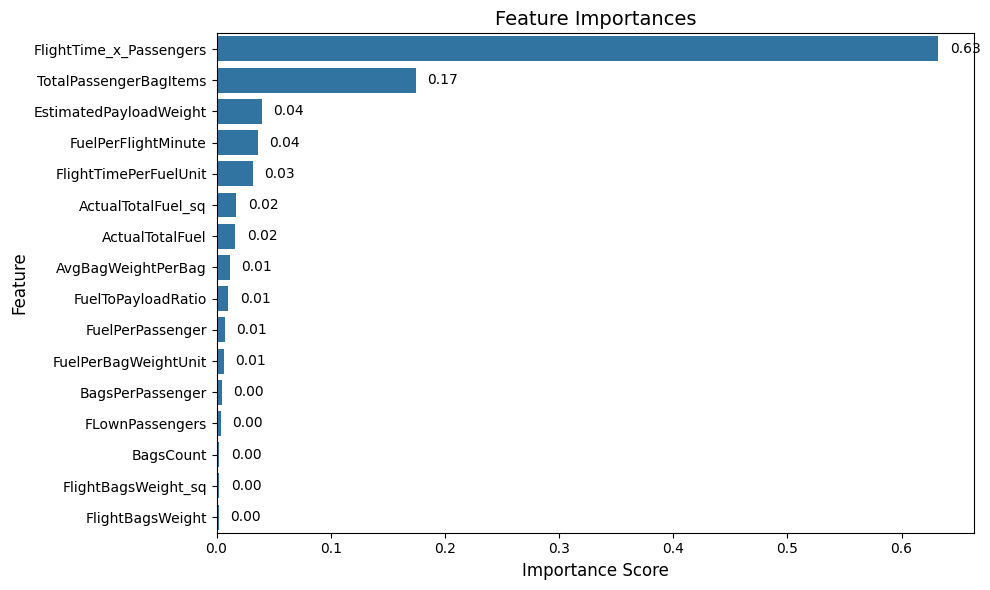

In [50]:
feature_importances = pd.Series(model.feature_importances_, index=X_train_with_fetures.drop(columns=cols_to_drop).columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importances.values, y=feature_importances.index)

# Dodanie wartości na słupkach
for i, v in enumerate(feature_importances.values):
    ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center')

# Tytuł i opisy osi
plt.title('Feature Importances', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

The feature importance chart shows that the newly created features affect the model results. Dominant on the results is mainly one feature `FlightTime_x_Passengers`. This is something new (comparing to the initial data, where the `ActualTotalFuel` trait had the greatest impact on the model's results.)

The iterations also show that the best combination of features is: 

['ActualTotalFuel', 'FLownPassengers', 'BagsCount', 'FlightBagsWeight',
       'AvgBagWeightPerBag', 'BagsPerPassenger', 'TotalPassengerBagItems',
       'FuelPerPassenger', 'FuelPerFlightMinute', 'FuelPerBagWeightUnit',
       'FlightTime_x_Passengers', 'ActualTotalFuel_sq', 'FlightBagsWeight_sq',
       'EstimatedPayloadWeight', 'FuelToPayloadRatio',
       'FlightTimePerFuelUnit']